In this notebook, we consider a ZDT1 problem with Gaussian noise, and benckmark two "denoising" methods:
* a naive average method,
* the KNN-Avg algorithm.

In [1]:
import nmoo

The first step is to construct our problem pipelines. We start with a `ZDT1` instance, that we wrap in a `ProblemWrapper`. In nmoo, `ProblemWrapper` is the base class to modify problems, in our case adding and removing noise. Additionally, `ProblemWrapper` and classes deriving from it maintain a history of every call made to their `_evaluate` method (see the [pymoo documentation](https://pymoo.org/getting_started.html#By-Class)).

Next, we add a Gaussian noise of type `N(0, 0.25)` and the averaging algorithm.

In [2]:
from pymoo.problems.multi import ZDT1

zdt1 = ZDT1()
wrapped_zdt1_1 = nmoo.WrappedProblem(zdt1)
noisy_zdt1_1 = nmoo.noises.GaussianNoise(
    wrapped_zdt1_1, 
    {"F": (0.0, 0.25)},
)
avg_zdt1 = nmoo.denoisers.Average(noisy_zdt1_1, n_evaluations=10)

We construct a similar pipeline for the KNN-Avg algorithm. Note that although we can reuse the same pymoo `Problem` instance (in this case, `zdt1`), it is advised to create a new wrapped problem and a new noisy problem, since nmoo `ProblemWrapper` is stateful.

In [3]:

wrapped_zdt1_2 = nmoo.WrappedProblem(zdt1)
noisy_zdt1_2 = nmoo.noises.GaussianNoise(
    wrapped_zdt1_2, 
    {"F": (0.0, 0.25)},
)
knnavg_zdt1 = nmoo.denoisers.KNNAvg(
    noisy_zdt1_2,
    distance_weight_type="squared",
    max_distance=1.0,
    n_neighbors=100,
)

Now, we setup an algorithm that will try and solve our `avg_zdt1` and `knnavg_zdt1` problems.

In [4]:
from pymoo.algorithms.nsga2 import NSGA2

nsga2 = NSGA2(
    pop_size=40,
    n_offsprings=10,
    eliminate_duplicates=True,
)

Finally, we setup our benchmark. It will run NSGA2 against `avg_zdt1` and `knnavg_zdt1` five times each. Additionally, we specify a Pareto front population to measure the performance, not of NSGA2, but of KNN-Avg against the averaging method.

This benchmark only features one algorithm, but it is of course possible to have more.

In [5]:
from pymoo.factory import get_termination

pareto_front = zdt1.pareto_front(100)

benchmark = nmoo.benchmark.Benchmark(
    problems={
        "knnavg": {
            "problem": knnavg_zdt1,
            "pareto_front": pareto_front,
        },
        "avg": {
            "problem": avg_zdt1,
            "pareto_front": pareto_front,
        },
    },
    algorithms={
        "nsga2": {
            "algorithm": nsga2,
        },
        "nsga2_5": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 10),
        },
        "nsga2_100": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 100),
        },
    },
    n_runs=5,
)

In [6]:
%%time
benchmark.run(verbose=50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

We now dump all results and histories for later analysis

In [7]:
OUT_PATH = "./out"
if not os.path.isdir(OUT_PATH):
    os.mkdir(OUT_PATH)
benchmark.dump_everything(OUT_PATH)

The following file should appear in `./out`:
* `avg.1.npz`: `avg_zdt1` call history;
* `avg.2.npz`: `noisy_zdt1_1` call history;
* `avg.3.npz`: `wrapped_zdt1_1` call history;
* `benchmark.csv`: benchmark results;
* `knnavg.1.npz`: `knnavg_zdt1` call history;
* `knnavg.2.npz`: `noisy_zdt1_1` call history;
* `knnavg.3.npz`: `wrapped_zdt1_1` call history.

In [8]:
! ls -l ./out

total 896
-rw-r--r--  1 cedric  staff      22 Jun  7 11:20 avg.1.npz
-rw-r--r--  1 cedric  staff      22 Jun  7 11:20 avg.2.npz
-rw-r--r--  1 cedric  staff      22 Jun  7 11:20 avg.3.npz
-rw-r--r--  1 cedric  staff  433450 Jun  7 11:20 benchmark.csv
-rw-r--r--  1 cedric  staff      22 Jun  7 11:20 knnavg.1.npz
-rw-r--r--  1 cedric  staff      22 Jun  7 11:20 knnavg.2.npz
-rw-r--r--  1 cedric  staff      22 Jun  7 11:20 knnavg.3.npz


Let's now visualize the results. The final result of each of the 6 runs can be found using the `Benchmark.final_results` method:

In [9]:
benchmark.final_results()

,algorithm,problem,n_run,n_gen,timedelta,perf_gd,perf_gd+,perf_igd,perf_igd+
0,nsga2,avg,1,285,289160,0.717687,0.714421,0.414212,0.412846
1,nsga2,avg,2,220,585618,0.776045,0.773661,0.550535,0.550303
2,nsga2,avg,3,340,523739,0.497999,0.495565,0.441413,0.441115
3,nsga2,avg,4,245,149146,1.074719,1.072957,0.881877,0.881734
4,nsga2,avg,5,305,634493,0.605162,0.602166,0.333872,0.333788
5,nsga2,knnavg,1,195,147213,1.268158,1.254180,0.757988,0.754558
6,nsga2,knnavg,2,215,709872,1.340710,1.314123,0.655959,0.651985
7,nsga2,knnavg,3,173,560333,0.959276,0.942014,0.410441,0.409428
8,nsga2,knnavg,4,255,206326,0.720717,0.699764,0.351634,0.351617
9,nsga2,knnavg,5,254,235516,1.343955,1.327100,0.855279,0.826841


The following boxplot indicates that, with the same number of calls to `ZDT1`, KNN-Avg offers a better GD+ performance. However, on the number of generation is fixed or unconstrained, then the averaging method is better.

<AxesSubplot:xlabel='problem', ylabel='perf_gd+'>

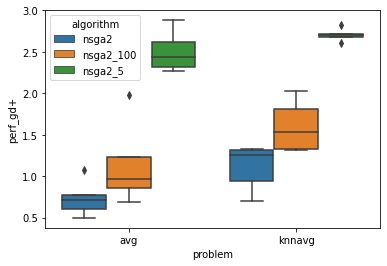

In [10]:
import seaborn as sns

sns.boxplot(
    x="problem", 
    y="perf_gd+", 
    hue="algorithm",
    data=benchmark.final_results(),
)

KNN-Avg also runs slightly faster (when the number of generation is reasonable), since fewer calls are made to the underlying problem. The difference can become significant if the base problem is costly to evaluate.

<AxesSubplot:xlabel='problem', ylabel='timedelta'>

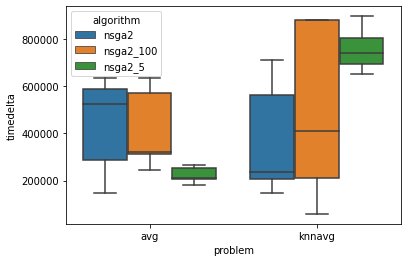

In [11]:
sns.boxplot(
    x="problem", 
    y="timedelta", 
    hue="algorithm",
    data=benchmark.final_results(),
)